In [50]:
import os
import urllib.error
import urllib.request
from pathlib import Path
import pandas as pd
import requests
import json
from collections import Counter
import glob
import numpy as np
from datetime import datetime, timedelta

import h5py
import matplotlib.pyplot as plt
import batman
import emcee
import corner
import tqdm

In [51]:
# Load the final filtered mnemonics data
filtered_mnemonics_folder = 'filter4_nonbinary&nonunique_mnemonics'
csv_files = glob.glob(os.path.join(filtered_mnemonics_folder, "*.csv"))

filtered_mnemonics = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    filtered_mnemonics.append(df)
# List all filenames in the filtered_mnemonics_folder
filenames = os.listdir(filtered_mnemonics_folder)
print(filenames[:5])  # Print first 5 filenames for inspection
# Extract mnemonics by splitting on the first hyphen
mnemonics_filtered_name= [filename.split('-')[0] for filename in filenames]
print(mnemonics_filtered_name[:5])  # Print first 5 mnemonics for inspection
print(f"Total mnemonics: {len(mnemonics_filtered_name)}")  # Print total count of mnemonics

['ICHS_CPU_UTIL-20231123T012334-20231125T065647.csv', 'ICSP_FREE_BLOCKS_CUR-20231123T012334-20231125T065647.csv', 'ICSP_USED_SPACE_CUR-20231123T012334-20231125T065647.csv', 'IDRV_MIR_IC_GRP_CNT-20231123T012334-20231125T065647.csv', 'IDRV_MIR_IC_INT_CNT-20231123T012334-20231125T065647.csv']
['ICHS_CPU_UTIL', 'ICSP_FREE_BLOCKS_CUR', 'ICSP_USED_SPACE_CUR', 'IDRV_MIR_IC_GRP_CNT', 'IDRV_MIR_IC_INT_CNT']
Total mnemonics: 1133


In [52]:
# Check for NaN values in each mnemonic and remove those with NaNs
mnemonics_no_nan = []
mnemonics_filtered_name_no_nan = []

for i, df in enumerate(filtered_mnemonics):
    euvalue = df['euvalue']
    if euvalue.isna().any():
        print(f"Mnemonic {mnemonics_filtered_name[i]} (index {i}) contains NaN and will be removed.")
    else:
        mnemonics_no_nan.append(df)
        mnemonics_filtered_name_no_nan.append(mnemonics_filtered_name[i])

print(f"Number of mnemonics after removing those with NaNs: {len(mnemonics_no_nan)}")


Number of mnemonics after removing those with NaNs: 1133


In [53]:
filtered_mnemonics = mnemonics_no_nan

In [54]:
# Remove mnemonics whose 'sqldataType' is 'varchar'
mnemonics_no_varchar = []
mnemonics_filtered_name_no_varchar = []

for i, df in enumerate(mnemonics_no_nan):
    # Check if any value in 'sqldataType' column is 'varchar'
    if (df['sqldataType'] == 'varchar').any():
        print(f"Removing mnemonic {mnemonics_filtered_name_no_nan[i]} (index {i}) due to varchar type.")
    else:
        mnemonics_no_varchar.append(df)
        mnemonics_filtered_name_no_varchar.append(mnemonics_filtered_name_no_nan[i])

print(f"Number of mnemonics after removing varchar types: {len(mnemonics_no_varchar)}")

Number of mnemonics after removing varchar types: 1133


In [55]:
filtered_mnemonics = mnemonics_no_varchar

In [56]:
print(f"Shape of filtered_mnemonics[{0}]: {filtered_mnemonics[0].shape}")
print(f"Columns of filtered_mnemonics[{0}]: {filtered_mnemonics[0].columns.tolist()}")

Shape of filtered_mnemonics[0]: (37657, 4)
Columns of filtered_mnemonics[0]: ['theTime', 'MJD', 'euvalue', 'sqldataType']


In [57]:
# Check for duplicate 'theTime' values in each mnemonic DataFrame
duplicate_theTime_count = 0
duplicate_mjd_count = 0

for i, df in enumerate(filtered_mnemonics):
    has_dup_theTime = df['theTime'].duplicated().any()
    has_dup_mjd = df['MJD'].duplicated().any()
    if has_dup_theTime:
        duplicate_theTime_count += 1
        print(f"Duplicate 'theTime' values found in mnemonic {mnemonics_filtered_name[i]} (index {i})")
        plt.figure(figsize=(5, 3))
        plt.plot(df['MJD'], df['euvalue'], '.', label=f'{mnemonics_filtered_name[i]}')
        plt.xlabel('MJD')
        plt.ylabel('euvalue')
        plt.title(f'Mnemonic {mnemonics_filtered_name[i]} (index {i}) with duplicate times')
        plt.legend()
        plt.tight_layout()
        plt.show()
    if has_dup_mjd:
        duplicate_mjd_count += 1

print(f"Number of mnemonics with duplicate 'theTime': {duplicate_theTime_count}")
print(f"Number of mnemonics with duplicate 'MJD': {duplicate_mjd_count}")

Number of mnemonics with duplicate 'theTime': 0
Number of mnemonics with duplicate 'MJD': 0


### Load the light curve data

In [58]:
# Set filename
fn = "combined_prepared_light_curve.h5"

# Load H5 file
with h5py.File(fn, 'r') as f:
    # Read all the data into a dictionary
    data = {key: f[key][()] for key in f.keys()}

    # Show the keys
    print('Keys in the data dictionary:')
    print(data.keys())

Keys in the data dictionary:
dict_keys(['bjd_binned', 'flux_binned', 'flux_err_binned', 'white_binned', 'white_err_binned'])


In [59]:
# Inspect the data

# Get the bjd and flux
bjd_binned = data['bjd_binned']

flux = data['flux_binned']
flux_err = data['flux_err_binned']

white = data['white_binned']
white_err = data['white_err_binned']

print("bjd_binned.shape = ", data['bjd_binned'].shape)
print("flux_binned.shape = ", data['flux_binned'].shape)
print("white_binned.shape = ", data['white_binned'].shape)


bjd_binned.shape =  (3906,)
flux_binned.shape =  (3906,)
white_binned.shape =  (3906,)


In [60]:
from astropy.time import Time

# Convert BJD to MJD
t = Time(bjd_binned, format='jd', scale='tdb')
t_utc = t.utc
mjd_utc = t_utc.mjd

mjd_lightcurve = mjd_utc  # MJD from light curve

print("MJD (UTC):", mjd_lightcurve.shape)  # Print first 5 MJD values for inspection
print("MJD (UTC) values:", mjd_lightcurve[:3])  # Print first 5 MJD values for inspection

MJD (UTC): (3906,)
MJD (UTC) values: [60271.05723226 60271.05769291 60271.05815355]


In [61]:
print(mjd_lightcurve[1]-mjd_lightcurve[0])

0.0004606475049513392


In [62]:
# The time resolution is the median difference between consecutive MJD values in the light curve
time_resolution = np.median(np.diff(mjd_lightcurve))
print(f"Time resolution of the light curve data: {time_resolution:.8f} days")

Time resolution of the light curve data: 0.00046065 days


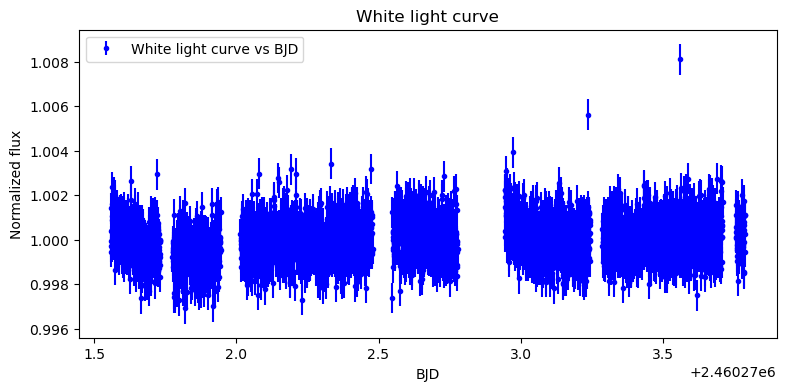

In [63]:
plt.figure(figsize=(9, 4))
plt.errorbar(bjd_binned, white, white_err, label='White light curve vs BJD', fmt='.', color='blue')
plt.xlabel('BJD')
plt.ylabel('Normalized flux')
plt.title('White light curve')
plt.legend()
plt.show()

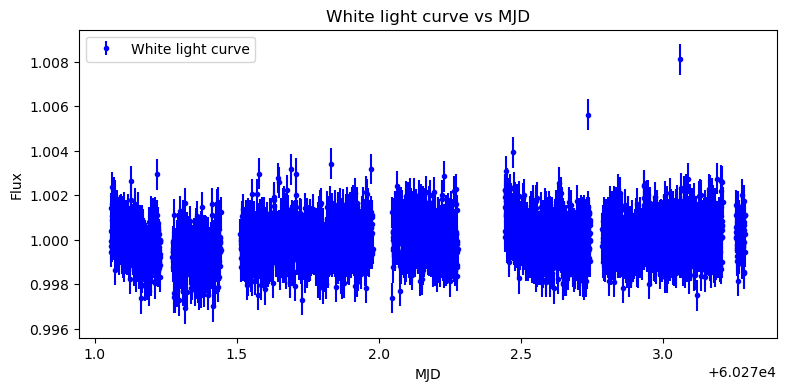

In [64]:
plt.figure(figsize=(9, 4))
plt.errorbar(mjd_lightcurve, white, white_err, label='White light curve', fmt='.', color='blue')
plt.xlabel('MJD')
plt.ylabel('Flux')
plt.title('White light curve vs MJD')
plt.legend()
plt.show()

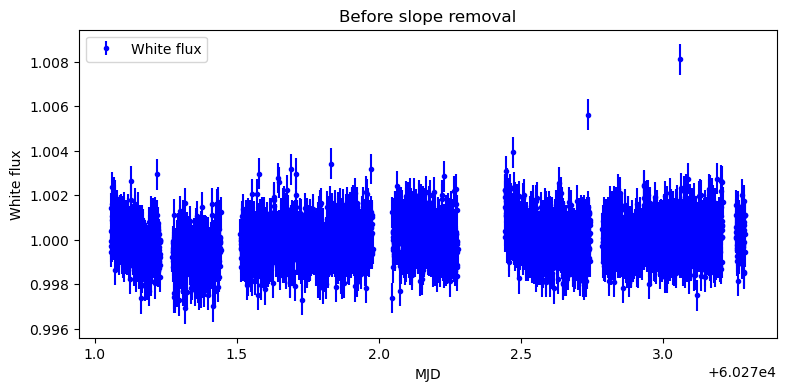

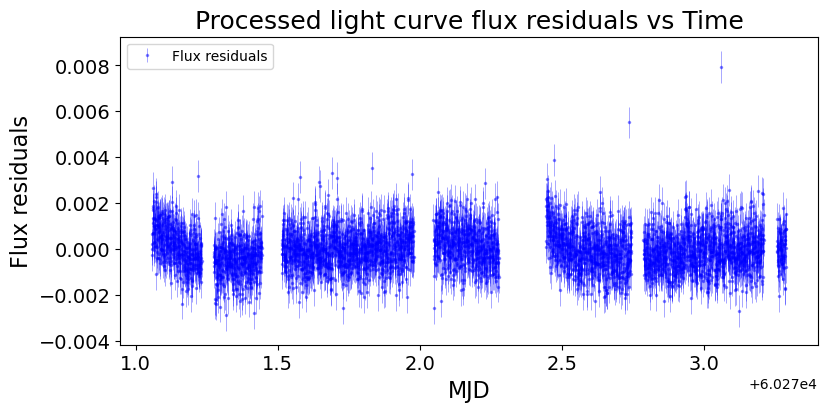

In [65]:
# Fit a line (degree 1 polynomial) to the white flux
coeffs = np.polyfit(mjd_lightcurve, white, 1)
trend = np.polyval(coeffs, mjd_lightcurve)
white_residuals = white - trend

plt.figure(figsize=(9, 4))
plt.errorbar(mjd_lightcurve, white, white_err, label='White flux', fmt='.', color='blue')
plt.xlabel('MJD')
plt.ylabel('White flux')
plt.title('Before slope removal')
plt.legend()
plt.show()

plt.figure(figsize=(9, 4))
plt.errorbar(mjd_lightcurve, white_residuals, white_err, label='Flux residuals', fmt='.', color='blue', alpha=0.4, markersize=3, linewidth=0.6)
plt.xlabel('MJD', fontsize=16)
plt.ylabel('Flux residuals', fontsize=16)
plt.title('Processed light curve flux residuals vs Time', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

In [66]:
print(len(mjd_lightcurve))

3906


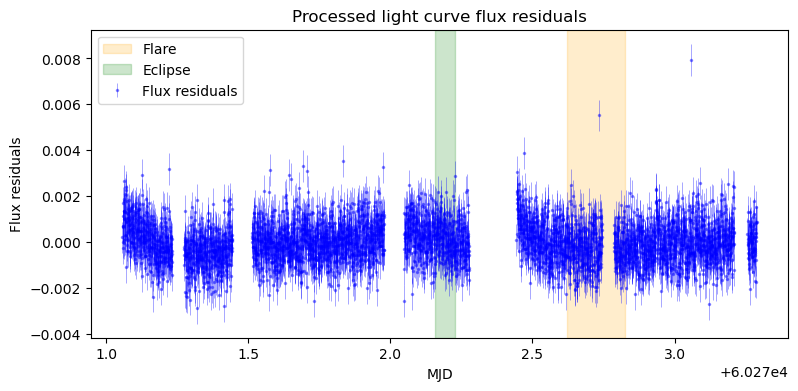

In [67]:
N_ramp = 500 

t1_start = 880
t1_end = 970
Dt1 = t1_end - t1_start

t2_start = 1340
t2_end = 1490

t3_start = 4155
t3_end = 4245

t4_start = 5165
t4_end = 5265

e_start = 2500
e_end = 2650

f_start = 3150
f_end = 3500

transit_indices = [(t1_start - N_ramp, t1_end - N_ramp),   # Transit 1
                   (t2_start - N_ramp, t2_end - N_ramp),   # Transit 2
                   (t3_start - N_ramp, t3_end - N_ramp),   # Transit 3
                   (t4_start - N_ramp, t4_end - N_ramp)]   # Transit 4

flare_indices = (f_start - N_ramp, f_end - N_ramp)  # Flare between transit 2 and 3

eclipse_indices = (e_start - N_ramp, e_end - N_ramp)  # Eclipse between transit 2 and 3

plt.figure(figsize=(9, 4))
plt.errorbar(mjd_lightcurve, white_residuals, white_err, label='Flux residuals', fmt='.', color='blue', alpha=0.4, markersize=3, linewidth=0.6)

# Highlight transits
#for i, (start, end) in enumerate(transit_indices, 1):
    #plt.axvspan(mjd_lightcurve[start], mjd_lightcurve[end], color='red', alpha=0.2, label=f'Transit {i}' if i == 1 else None)

# Highlight flare
plt.axvspan(mjd_lightcurve[flare_indices[0]], mjd_lightcurve[flare_indices[1]], color='orange', alpha=0.2, label='Flare')

# Highlight eclipse
plt.axvspan(mjd_lightcurve[eclipse_indices[0]], mjd_lightcurve[eclipse_indices[1]], color='green', alpha=0.2, label='Eclipse')

plt.xlabel('MJD')
plt.ylabel('Flux residuals')
plt.title('Processed light curve flux residuals')
plt.legend()
plt.show()

In [68]:
example = 8  # Example index to demonstrate

mjd_mnemonic_example = filtered_mnemonics[example]['MJD'].values
print("Example mnemonic MJD:\n", mjd_mnemonic_example)

utc_mnemonic_example = filtered_mnemonics[example]['theTime'].values
print("Example mnemonic UTC:\n", utc_mnemonic_example)

value_mnemonic_example = filtered_mnemonics[example]['euvalue'].values
print("Example mnemonic values:\n", value_mnemonic_example)

Example mnemonic MJD:
 [60271.05798855 60271.05803596 60271.05810707 ... 60273.28935744
 60273.28940485 60273.28945226]
Example mnemonic UTC:
 ['2023-11-23 01:23:30.211000' '2023-11-23 01:23:34.307000'
 '2023-11-23 01:23:40.451000' ... '2023-11-25 06:56:40.483000'
 '2023-11-25 06:56:44.579000' '2023-11-25 06:56:48.675000']
Example mnemonic values:
 [2.62034273 3.01990747 2.86822081 ... 1.57703447 1.63622928 1.58813345]


In [69]:
print(np.min(mjd_lightcurve), np.max(mjd_lightcurve))
print(np.min(mjd_mnemonic_example), np.max(mjd_mnemonic_example))
# Check the overlap between mnemonics and light curve MJD

print(mjd_lightcurve.shape, mjd_mnemonic_example.shape)

60271.05723225853 60273.28863653128
60271.0579885532 60273.2894522569
(3906,) (45188,)


In [70]:
import scipy
print(scipy.__version__)

1.11.4


In [71]:
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler

# Step 1: Keep only the 'mjd' and 'euvalue' column for each mnemonic

mjd_mnemonics = []
euvalues = []
for df in filtered_mnemonics:
    mjd_mnemonics.append(df['MJD'].values)
    # Standardize each mnemonic's euvalue
    scaler = StandardScaler()
    eu_std = scaler.fit_transform(df['euvalue'].values.reshape(-1, 1)).flatten()
    euvalues.append(eu_std)

# Step 2: Interpolate/extrapolate each standardized 'euvalue' to match the shape of 'white'
white_len = white.shape[0]
white_time = mjd_lightcurve

euvalues_interp = []
for i, df in enumerate(filtered_mnemonics):
    f_interp = interp1d(mjd_mnemonics[i], euvalues[i], kind='cubic', 
                        bounds_error=False, fill_value=0)
    eu_interp = f_interp(white_time)
    euvalues_interp.append(eu_interp)

# Step 3: Stack all interpolated euvalue columns as features
X = np.column_stack(euvalues_interp)
y = white_residuals  # Output variable

print(X.shape)
print(y.shape)

# Step 4: Create a DataFrame for ML analysis (e.g., PCA)
feature_names = [f'euvalue_{i}_{mnemonics_filtered_name[i]}' for i in range(len(euvalues_interp))]
ml_df = pd.DataFrame(X, columns=feature_names)
ml_df['white_res'] = y

print(ml_df.head())
print("Shape of ML DataFrame:", ml_df.shape)


(3906, 1133)
(3906,)
   euvalue_0_ICHS_CPU_UTIL  euvalue_1_ICSP_FREE_BLOCKS_CUR  \
0                 0.000000                        0.000000   
1                 0.000000                        0.000000   
2                -0.243457                       -0.066380   
3                -0.593188                       -0.260137   
4                 0.114396                        1.192655   

   euvalue_2_ICSP_USED_SPACE_CUR  euvalue_3_IDRV_MIR_IC_GRP_CNT  \
0                       0.000000                       0.000000   
1                       0.000000                       0.000000   
2                      -0.048041                       0.659779   
3                      -0.073410                       0.715519   
4                      -0.329927                       0.707578   

   euvalue_4_IDRV_MIR_IC_INT_CNT  euvalue_5_IFGS_ACKG1_FC  \
0                       0.000000                 0.000000   
1                       0.000000                 0.000000   
2                   

[60271.05800337 60271.05806263 60271.05812189 60271.05818115
 60271.05824041]
[-0.02623606  3.50086819  0.33571249 -0.17884442  0.05377445]
(37657,)
(37657,)


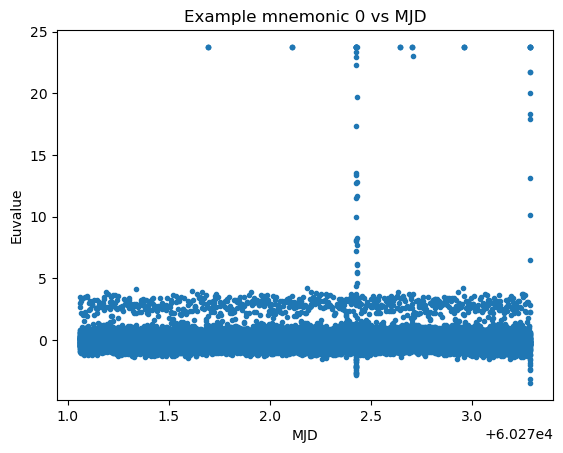

In [72]:
example_index = 0  # Example index to plot
plt.plot(mjd_mnemonics[example_index], euvalues[example_index], '.', label=f'Mnemonic {mnemonics_filtered_name[example_index]}')
plt.xlabel('MJD')
plt.ylabel('Euvalue')
plt.title('Example mnemonic 0 vs MJD')

print(mjd_mnemonics[example_index][:5]) 
print(euvalues[example_index][:5])

print(mjd_mnemonics[example_index].shape) 
print(euvalues[example_index].shape)


Text(0.5, 1.0, 'Interpolated example mnemonic vs MJD')

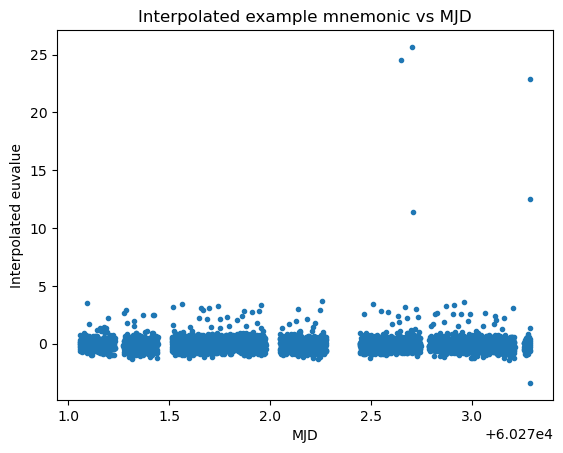

In [73]:
plt.plot(mjd_lightcurve, euvalues_interp[example_index], '.', label=f'Interpolated {mnemonics_filtered_name[example_index]}')
plt.xlabel('MJD')
plt.ylabel('Interpolated euvalue')
plt.title('Interpolated example mnemonic vs MJD')

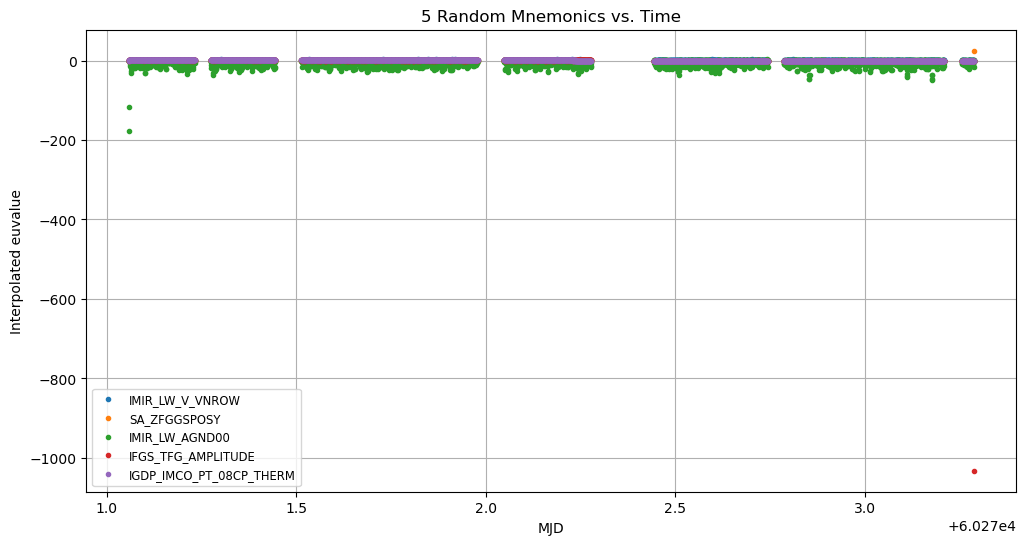

In [74]:
import random

# Randomly select 5 unique indices from available mnemonics
random_indices = random.sample(range(X.shape[1]), 5)

plt.figure(figsize=(12, 6))
for idx in random_indices:
    plt.plot(mjd_lightcurve, X[:, idx], '.', label=mnemonics_filtered_name[idx])
plt.xlabel('MJD')
plt.ylabel('Interpolated euvalue')
plt.title('5 Random Mnemonics vs. Time')
plt.legend(fontsize='small')
plt.grid()
plt.show()

# Pearson correlation

Top 20 mnemonics by absolute Pearson correlation with white flux:
Mnemonic                                     r        p-value
euvalue_306_IFGS_SCEG2_HKTLM_3_15       0.1247       5.10e-15
euvalue_938_IMIR_SW_TC_HSG_TEMP         0.1178       1.50e-13
euvalue_939_IMIR_SW_TC_I_DET_HTR        0.1140       8.87e-13
euvalue_424_IFSI_S7_TLM_ACC_CNT         0.1129       1.51e-12
euvalue_847_IMIR_LW_TC_HSG_TEMP         0.1036       8.75e-11
euvalue_695_IMIR_HK_PDU_TEMP           -0.0985       6.75e-10
euvalue_893_IMIR_PDU_TEMP              -0.0983       7.40e-10
euvalue_100_IFGS_ICEG2_STAT_GOODCNT    -0.0913       1.07e-08
euvalue_448_IGDP_IMCO_PT_24_CAL_LO      0.0905       1.44e-08
euvalue_421_IFSI_S6_CMD_ACC_CNT        -0.0886       2.95e-08
euvalue_852_IMIR_LW_TC_TS_TEMP          0.0861       7.08e-08
euvalue_781_IMIR_IC_TC_V_DET_HTR       -0.0858       7.87e-08
euvalue_449_IGDP_IMCO_PT_26_CAL_HI      0.0849       1.08e-07
euvalue_419_IFSI_S5_CMD_ACC_CNT        -0.0845       1.24e-07
euva

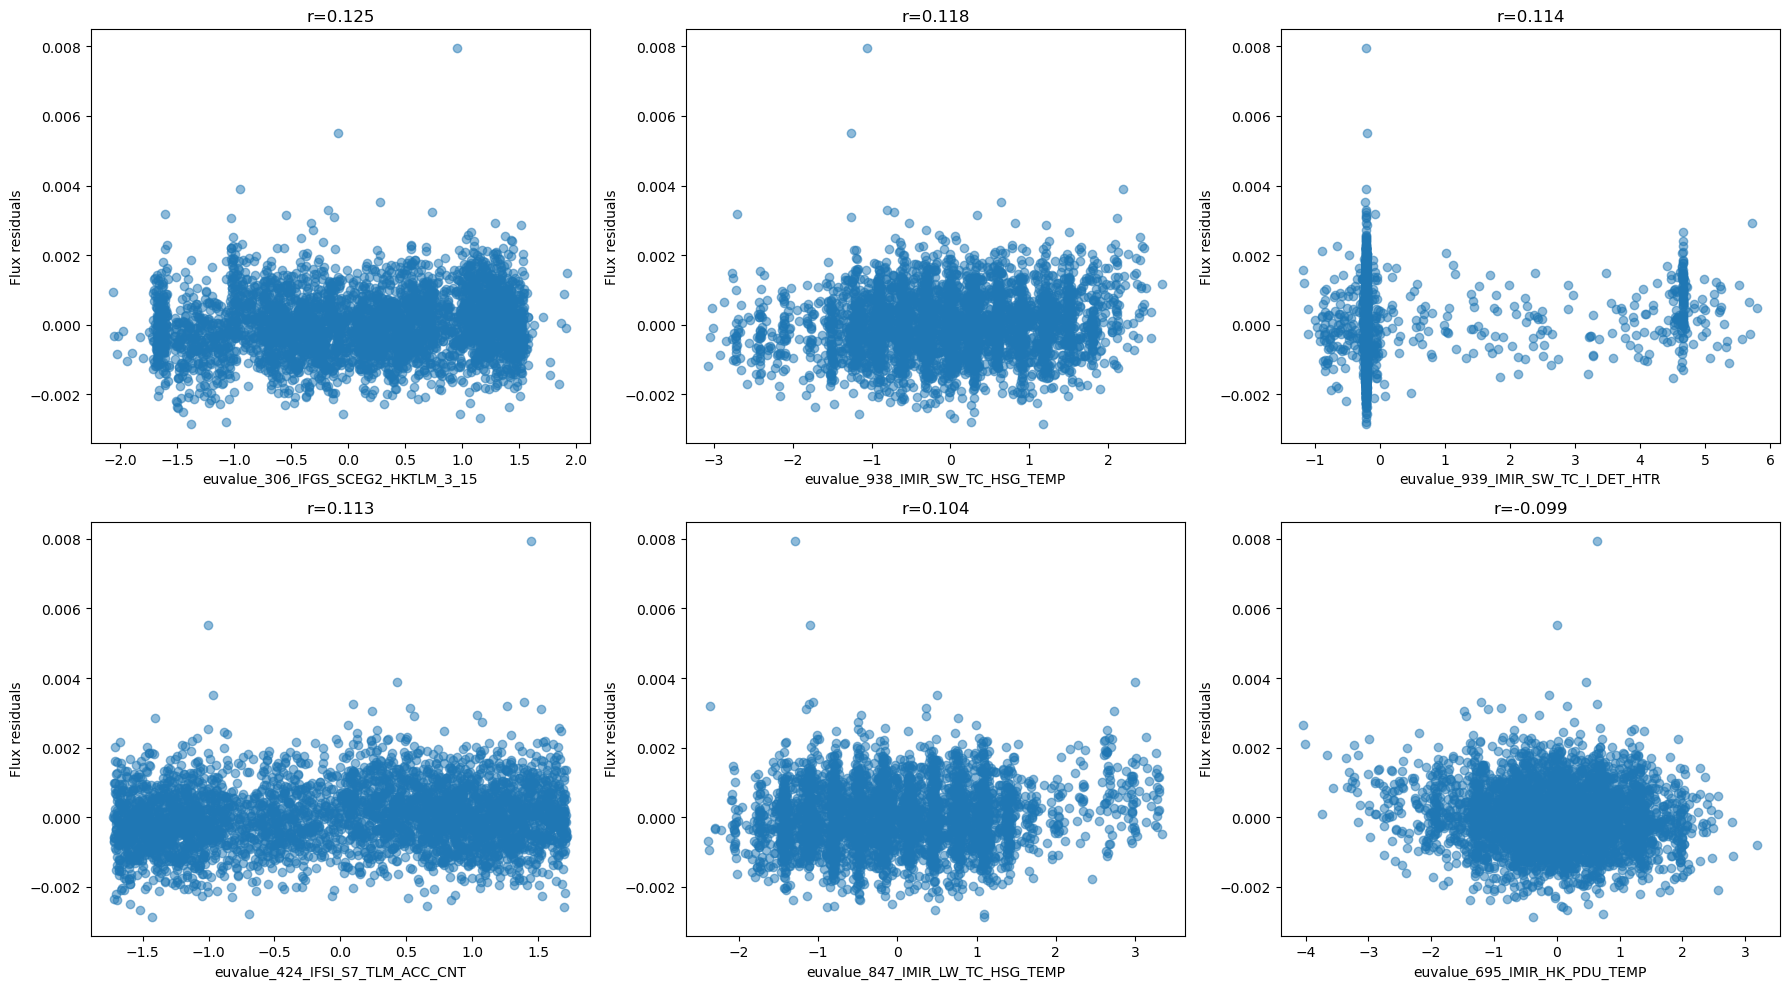

In [75]:
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient for each mnemonic vs. white flux

correlations = []
for i in range(X.shape[1]):
    r, p = pearsonr(X[:, i], y)
    correlations.append((i, r, p))

# Sort by absolute correlation value
correlations_sorted = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)

# Present top 50 most correlated mnemonics with aligned columns
n_top = 20
print(f"Top {n_top} mnemonics by absolute Pearson correlation with white flux:")
print(f"{'Mnemonic':<35} {'r':>10} {'p-value':>14}")
for idx, r, p in correlations_sorted[:n_top]:
    print(f"{feature_names[idx]:<35} {r:10.4f} {p:14.2e}")

# Optionally, plot the most correlated mnemonic vs. white flux
#top_idx = correlations_sorted[0][0]
#plt.figure(figsize=(6,4))
#plt.scatter(X[:, top_idx], y, alpha=0.5)
#plt.xlabel(feature_names[top_idx])
#plt.ylabel('White flux')
#plt.title(f'Correlation r={correlations_sorted[0][1]:.3f}')
#plt.show()

# Plot the 6 most correlated mnemonics vs. white flux in separate subplots (3x2 grid)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i in range(6):
    idx = correlations_sorted[i][0]
    ax = axes[i // 3, i % 3]
    ax.scatter(X[:, idx], y, alpha=0.5)
    ax.set_xlabel(feature_names[idx])
    ax.set_ylabel('Flux residuals')
    ax.set_title(f'r={correlations_sorted[i][1]:.3f}')
plt.tight_layout()
plt.show()

# Auto-correlation and time lags

Mnemonic                                Max Corr      Lag   Lag (days)
euvalue_847_IMIR_LW_TC_HSG_TEMP           0.1626     -453      -0.2087
euvalue_274_IFGS_SCEG2_HKTLM_1_30        -0.1506    -1485      -0.6841
euvalue_306_IFGS_SCEG2_HKTLM_3_15         0.1473      -93      -0.0428
euvalue_57_IFGS_ICEG1_STAT_GOODCNT        0.1469     2000       0.9213
euvalue_422_IFSI_S6_TLM_ACC_CNT          -0.1453     -158      -0.0728
euvalue_575_IMIR_HK_ACCEPTED_FC           0.1431     -399      -0.1838
euvalue_359_IFGS_TFG_AMPLITUDE           -0.1427     -399      -0.1838
euvalue_1005_SA_ZFGGSPOSY                 0.1426     -399      -0.1838
euvalue_1010_SA_ZGSTIME                  -0.1426     -399      -0.1838
euvalue_367_IFGS_TFG_SIGNOISERATIO        0.1426     -399      -0.1838
euvalue_1004_SA_ZFGGSPOSX                -0.1425     -399      -0.1838
euvalue_360_IFGS_TFG_CNTD                 0.1425     -399      -0.1838
euvalue_938_IMIR_SW_TC_HSG_TEMP           0.1417     -460      -0.2119
euvalu

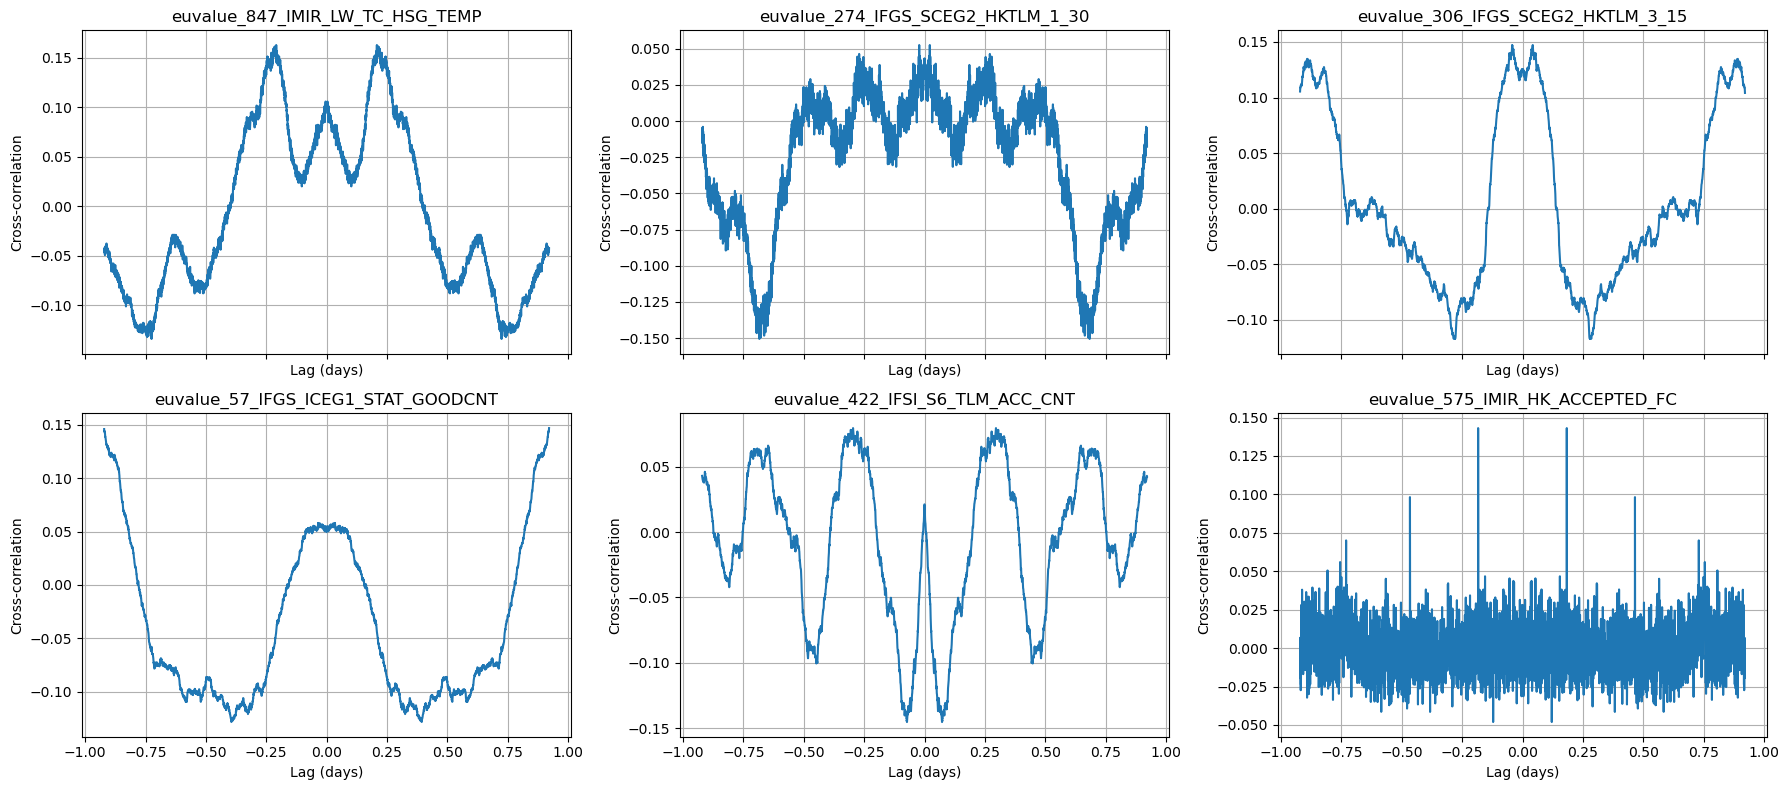

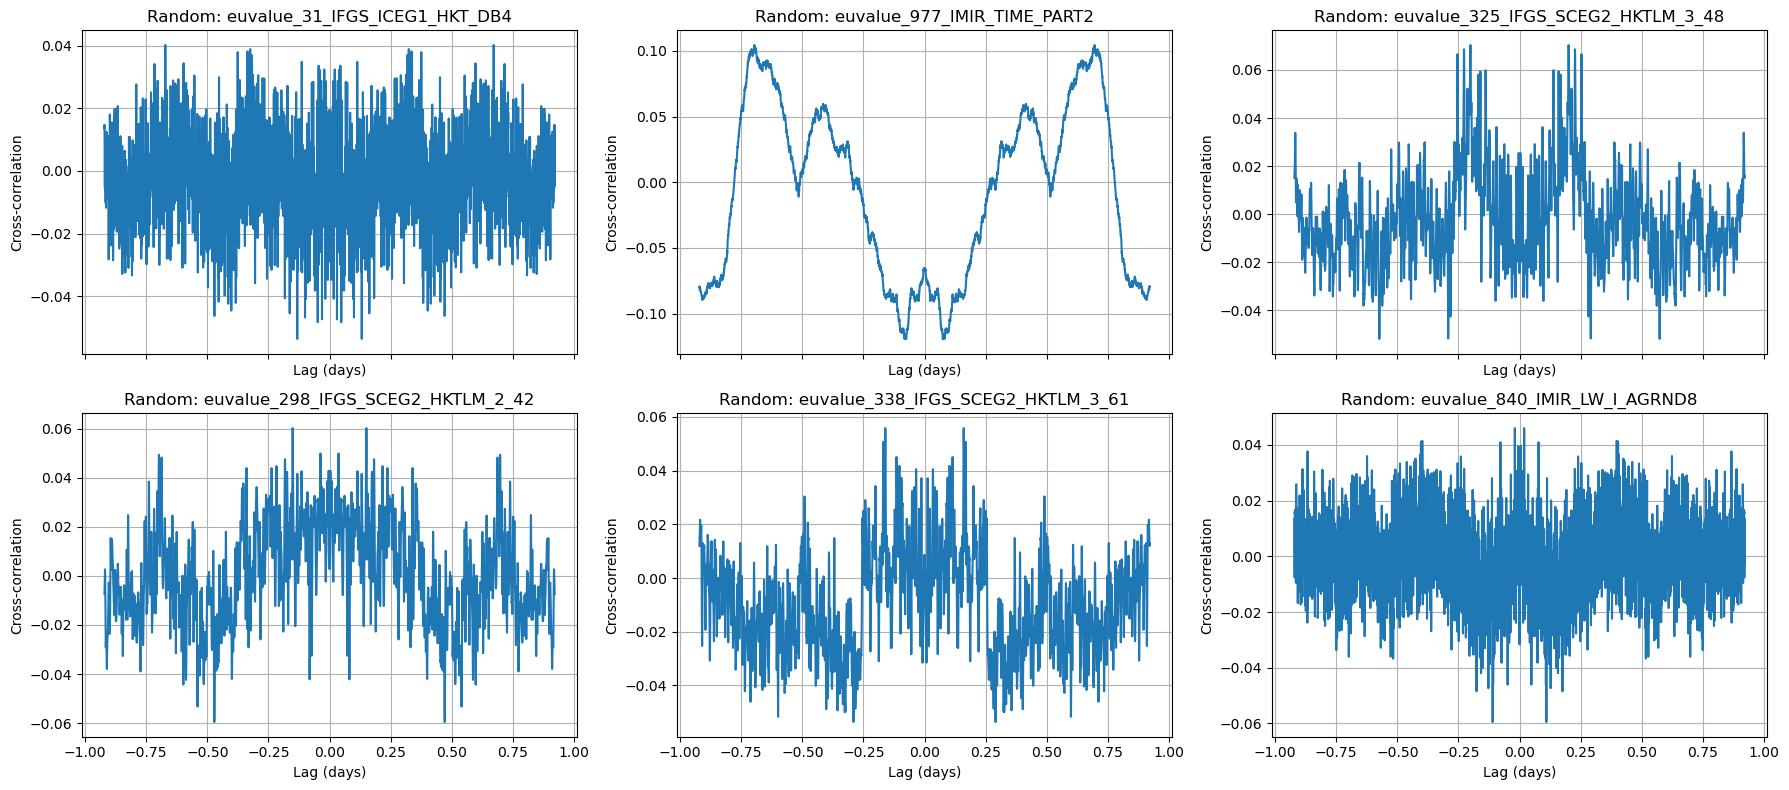

In [76]:
from statsmodels.tsa.stattools import ccf
import numpy as np
import random

max_lag = 2000  # Number of lags to check (can adjust as needed)
autocorr_results = {}
dt = np.median(np.diff(mjd_lightcurve))  # Time step in days

for i in range(X.shape[1]):
    # Cross-correlation function (mnemonic vs. white flux)
    c = ccf(X[:, i] - np.mean(X[:, i]), y - np.mean(y), adjusted=False)
    # Only keep up to max_lag lags in both directions
    c_full = np.concatenate([c[:max_lag][::-1], c[:max_lag+1]])
    autocorr_results[feature_names[i]] = c_full

# Lags in samples and in time units (days)
lags = np.arange(-max_lag, max_lag+1)
lags_time = lags * dt

# Find the lag with maximum absolute correlation for each mnemonic
results = []
for name, corr in autocorr_results.items():
    if np.any(np.isnan(corr)):
        continue  # Skip if any NaN in correlation
    lag_idx = np.argmax(np.abs(corr))
    lag = lags[lag_idx]
    lag_time = lags_time[lag_idx]
    results.append((name, corr[lag_idx], lag, lag_time))

# Sort by absolute max correlation
results_sorted = sorted(results, key=lambda x: abs(x[1]), reverse=True)
print(f"{'Mnemonic':<35} {'Max Corr':>12} {'Lag':>8} {'Lag (days)':>12}")
for name, max_corr, lag, lag_time in results_sorted[:20]:
    print(f"{name:<35} {max_corr:12.4f} {lag:8} {lag_time:12.4f}")

# Optionally, plot the cross-correlation for the top mnemonic
if results_sorted:
    top6 = results_sorted[:6]
    fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True)
    for i, (name, _, _, _) in enumerate(top6):
        ax = axes[i // 3, i % 3]
        ax.plot(lags_time, autocorr_results[name])
        ax.set_title(f'{name}')
        ax.set_xlabel('Lag (days)')
        ax.set_ylabel('Cross-correlation')
        ax.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No valid correlations found (all contained NaN values).")

# Plot 6 random cross-correlation results

if len(results_sorted) >= 6:
    random_indices = random.sample(range(len(results_sorted)), 6)
    fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True)
    for i, idx in enumerate(random_indices):
        name = results_sorted[idx][0]
        ax = axes[i // 3, i % 3]
        ax.plot(lags_time, autocorr_results[name])
        ax.set_title(f'Random: {name}')
        ax.set_xlabel('Lag (days)')
        ax.set_ylabel('Cross-correlation')
        ax.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough results to plot 6 random cross-correlations.")

# PCA

In [77]:
from sklearn.decomposition import PCA
# do standardisation
# Select only the feature columns for PCA
X_features = ml_df[feature_names].values

print(X_features.shape)
print(y.shape)

# Run PCA
pca = PCA()

X_pca = pca.fit_transform(X_features)


# Show explained variance ratio and first few PCA components
#print("Explained variance ratio:", pca.explained_variance_ratio_)

variance_perc = 0.9999
explained = np.cumsum(pca.explained_variance_ratio_)
n_components_999999 = np.searchsorted(explained, variance_perc) + 1
print(f"Number of principal components explaining {variance_perc} variance: {n_components_999999}")
print("First 6 rows of PCA components:\n", X_pca[:5])

(3906, 1133)
(3906,)
Number of principal components explaining 0.9999 variance: 813
First 6 rows of PCA components:
 [[-7.40703946e+01 -4.30716562e+01 -9.03471152e-01 ...  1.67006372e-13
   2.27949244e-13  4.64582537e-13]
 [-7.40701300e+01 -4.30724461e+01 -9.02617058e-01 ... -1.67155365e-13
  -2.27971945e-13 -4.64480398e-13]
 [ 1.98297379e+01 -4.57181874e+01  2.30164687e+00 ...  1.77513793e-13
   1.10119273e-13  1.92168300e-13]
 [-5.70443604e+01 -2.60848524e+01 -3.43097929e+00 ...  6.81092493e-15
  -1.94486441e-13 -4.22007933e-14]
 [-4.88480447e+01 -3.25309827e+00  4.27043124e+01 ... -3.44706897e-13
   2.58583513e-13 -3.42774264e-13]]


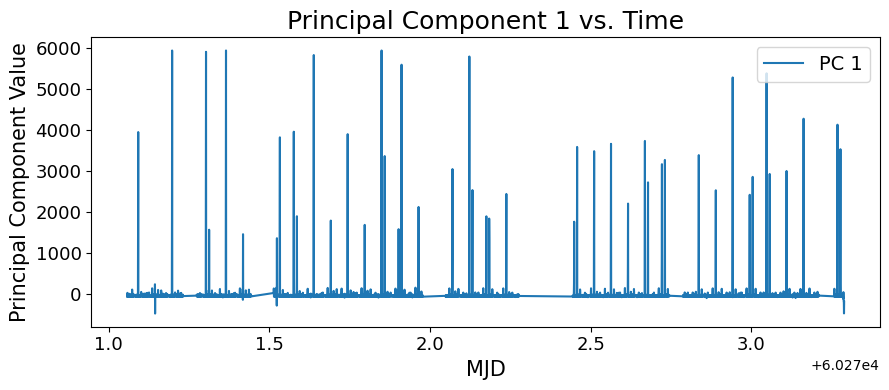

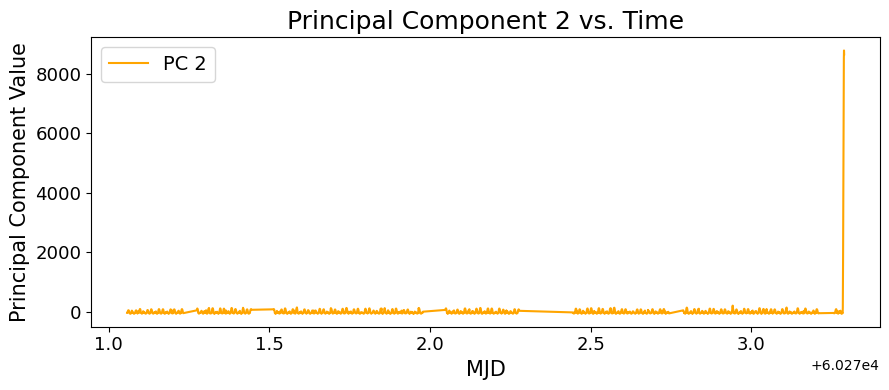

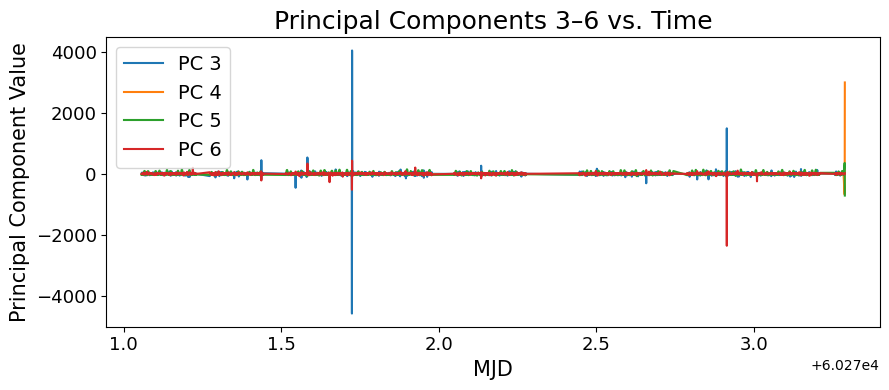

In [78]:
# Define font sizes
title_fs = 18
label_fs = 15
tick_fs = 13
legend_fs = 14

# Plot PC1
plt.figure(figsize=(9, 4))
plt.plot(white_time, X_pca[:, 0], label='PC 1')
plt.xlabel('MJD', fontsize=label_fs)
plt.ylabel('Principal Component Value', fontsize=label_fs)
plt.title('Principal Component 1 vs. Time', fontsize=title_fs)
plt.legend(fontsize=legend_fs)
plt.xticks(fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)
plt.tight_layout()
plt.show()

# Plot PC2
plt.figure(figsize=(9, 4))
plt.plot(white_time, X_pca[:, 1], label='PC 2', color='orange')
plt.xlabel('MJD', fontsize=label_fs)
plt.ylabel('Principal Component Value', fontsize=label_fs)
plt.title('Principal Component 2 vs. Time', fontsize=title_fs)
plt.legend(fontsize=legend_fs)
plt.xticks(fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)
plt.tight_layout()
plt.show()

# Plot PC3–PC6 together
plt.figure(figsize=(9, 4))
for i in range(2, 6):
    plt.plot(white_time, X_pca[:, i], label=f'PC {i+1}')
plt.xlabel('MJD', fontsize=label_fs)
plt.ylabel('Principal Component Value', fontsize=label_fs)
plt.title('Principal Components 3–6 vs. Time', fontsize=title_fs)
plt.legend(fontsize=legend_fs)
plt.xticks(fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)
plt.tight_layout()
plt.show()


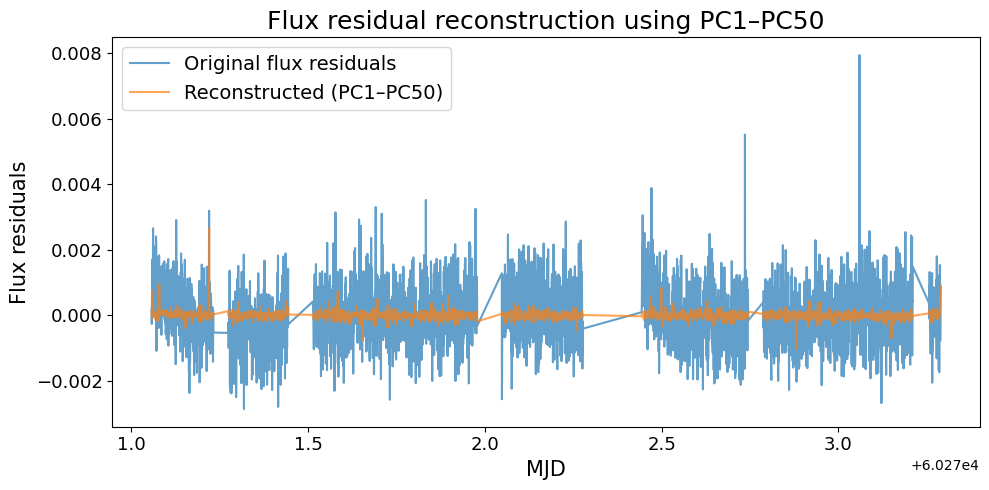

In [79]:
from sklearn.linear_model import LinearRegression

# Use first n_pc principal components to reconstruct the flux residuals
n_pc = 50
X_pca_n = X_pca[:, :n_pc]

# Reconstruct the features using only the first 50 PCs
X_recon = pca.inverse_transform(
    np.column_stack([X_pca[:, i] if i < n_pc else np.zeros_like(X_pca[:, 0]) for i in range(X_pca.shape[1])])
)

# Fit a linear model from the reconstructed features to the flux residuals
reg = LinearRegression()
reg.fit(X_recon, y)
y_pred = reg.predict(X_recon)

# Define font sizes (as in previous cell)
title_fs = 18
label_fs = 15
tick_fs = 13
legend_fs = 14

# Plot the reconstructed vs. original flux residuals
plt.figure(figsize=(10, 5))
plt.plot(white_time, y, label='Original flux residuals', alpha=0.7)
plt.plot(white_time, y_pred, label=f'Reconstructed (PC1–PC{n_pc})', alpha=0.7)
plt.xlabel('MJD', fontsize=label_fs)
plt.ylabel('Flux residuals', fontsize=label_fs)
plt.title(f'Flux residual reconstruction using PC1–PC{n_pc}', fontsize=title_fs)
plt.legend(fontsize=legend_fs)
plt.xticks(fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)
plt.tight_layout()
plt.show()


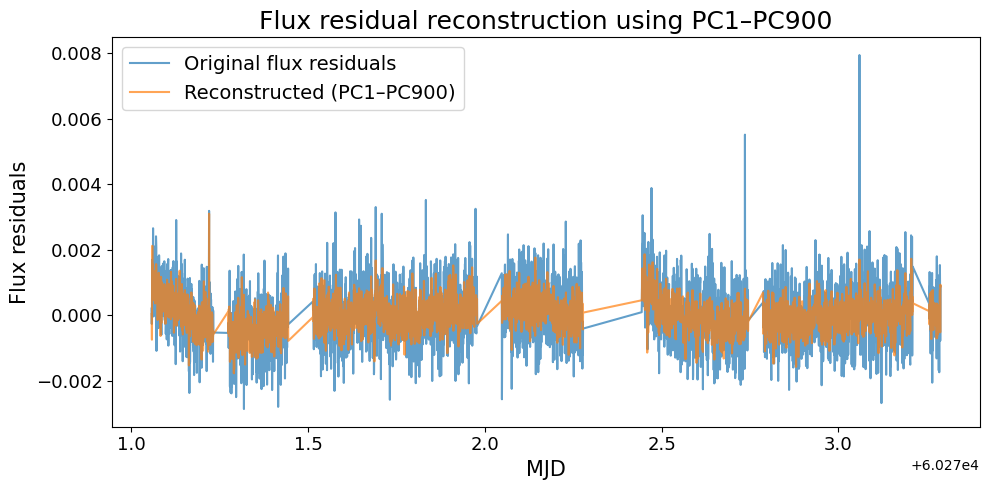

In [80]:
from sklearn.linear_model import LinearRegression

# Use first n_pc principal components to reconstruct the flux residuals
n_pc = 900
X_pca_n = X_pca[:, :n_pc]

# Reconstruct the features using only the first 50 PCs
X_recon = pca.inverse_transform(
    np.column_stack([X_pca[:, i] if i < n_pc else np.zeros_like(X_pca[:, 0]) for i in range(X_pca.shape[1])])
)

# Fit a linear model from the reconstructed features to the flux residuals
reg = LinearRegression()
reg.fit(X_recon, y)
y_pred = reg.predict(X_recon)

# Define font sizes (as in previous cell)
title_fs = 18
label_fs = 15
tick_fs = 13
legend_fs = 14

# Plot the reconstructed vs. original flux residuals
plt.figure(figsize=(10, 5))
plt.plot(white_time, y, label='Original flux residuals', alpha=0.7)
plt.plot(white_time, y_pred, label=f'Reconstructed (PC1–PC{n_pc})', alpha=0.7)
plt.xlabel('MJD', fontsize=label_fs)
plt.ylabel('Flux residuals', fontsize=label_fs)
plt.title(f'Flux residual reconstruction using PC1–PC{n_pc}', fontsize=title_fs)
plt.legend(fontsize=legend_fs)
plt.xticks(fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)
plt.tight_layout()
plt.show()


In [81]:
# Find which original euvalue features contribute to the first 350 principal components

# Get the PCA components matrix: shape (n_components, n_features)
components = pca.components_[:1]  # first 350 PCs
print(len(components))

# For each feature, check if its absolute loading is nonzero in any of the first 350 PCs
feature_included = np.any(np.abs(components) > 1e-12, axis=0)

included_features = [feature_names[i] for i, included in enumerate(feature_included) if included]

#print("Original euvalue features included in the first 350 principal components:")
#print(included_features)
print(f"Total included features: {len(included_features)}")

1
Total included features: 1133


# NEURAL NETWORK

Fold 1/5
  Final Train Loss: 0.017924, Final Val Loss: 0.019911
Fold 2/5
  Final Train Loss: 0.017679, Final Val Loss: 0.011032
Fold 3/5
  Final Train Loss: 0.016489, Final Val Loss: 0.004141
Fold 4/5
  Final Train Loss: 0.033248, Final Val Loss: 0.001803
Fold 5/5
  Final Train Loss: 0.033760, Final Val Loss: 0.027291


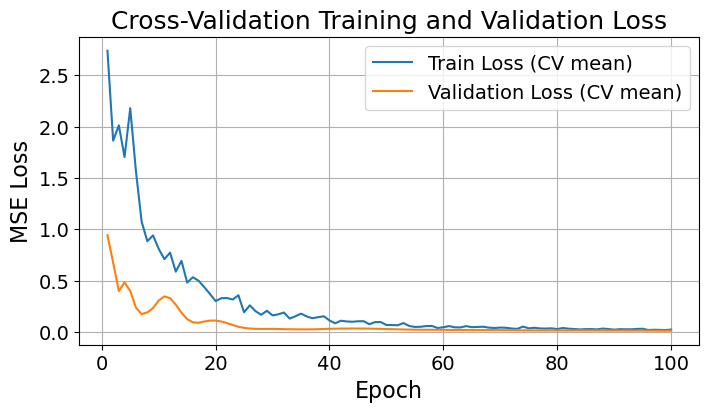

Epoch 10/100, Loss: 0.594520, Val Loss: 0.367188
Epoch 20/100, Loss: 0.419353, Val Loss: 0.133434
Epoch 30/100, Loss: 0.336949, Val Loss: 0.074735
Epoch 40/100, Loss: 0.103892, Val Loss: 0.072677
Epoch 50/100, Loss: 0.154455, Val Loss: 0.031210
Epoch 60/100, Loss: 0.101918, Val Loss: 0.048063
Epoch 70/100, Loss: 0.069391, Val Loss: 0.034031
Epoch 80/100, Loss: 0.047828, Val Loss: 0.033261
Epoch 90/100, Loss: 0.028784, Val Loss: 0.023107
Epoch 100/100, Loss: 0.063947, Val Loss: 0.026685


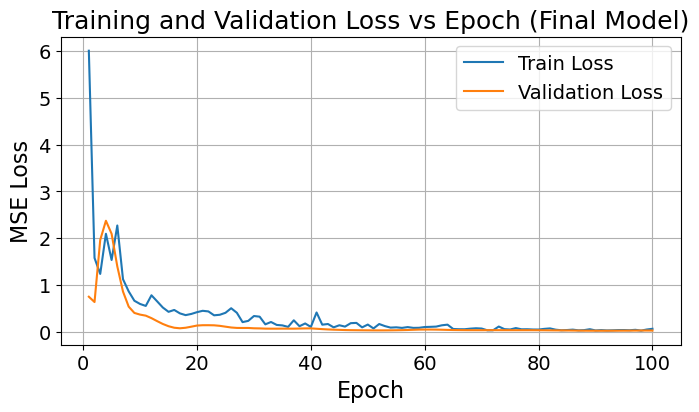

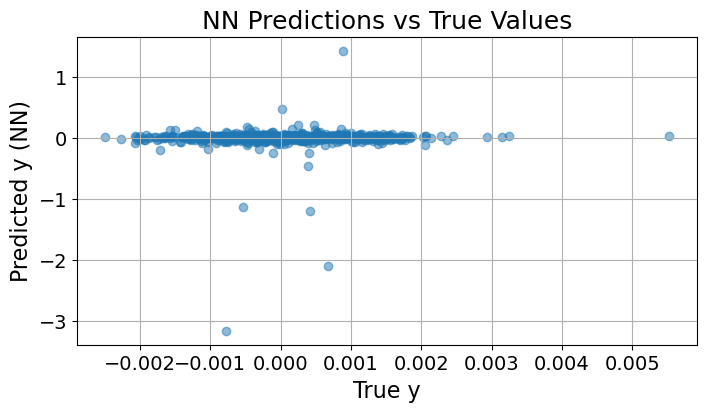

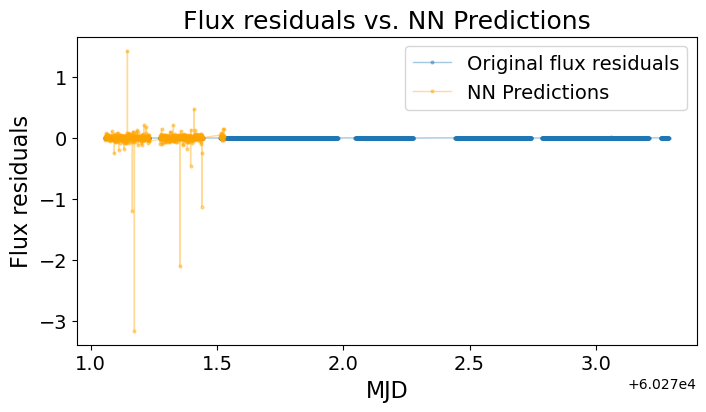

In [86]:
# Simple NN
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 96),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)


# Prepare data
X = ml_df[feature_names].values

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_train_losses = []
cv_val_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold+1}/{n_splits}")
    X_train_cv, X_val_cv = X[train_idx], X[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    X_train_cv_torch = torch.tensor(X_train_cv, dtype=torch.float32)
    X_val_cv_torch = torch.tensor(X_val_cv, dtype=torch.float32)
    y_train_cv_torch = torch.tensor(y_train_cv, dtype=torch.float32).unsqueeze(1)
    y_val_cv_torch = torch.tensor(y_val_cv, dtype=torch.float32).unsqueeze(1)

    model_cv = SimpleNN(X_train_cv.shape[1])

    optimizer_cv = optim.Adam(model_cv.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion_cv = nn.MSELoss()

    epochs = 100
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model_cv.train()
        optimizer_cv.zero_grad()
        output = model_cv(X_train_cv_torch)
        loss = criterion_cv(output, y_train_cv_torch)
        loss.backward()
        optimizer_cv.step()
        train_losses.append(loss.item())
        model_cv.eval()
        with torch.no_grad():
            val_loss = criterion_cv(model_cv(X_val_cv_torch), y_val_cv_torch)
            val_losses.append(val_loss.item())
    cv_train_losses.append(train_losses)
    cv_val_losses.append(val_losses)
    print(f"  Final Train Loss: {train_losses[-1]:.6f}, Final Val Loss: {val_losses[-1]:.6f}")
# Plot average loss curves across folds
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), np.mean(cv_train_losses, axis=0), label='Train Loss (CV mean)')
plt.plot(range(1, epochs+1), np.mean(cv_val_losses, axis=0), label='Validation Loss (CV mean)')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('MSE Loss', fontsize=16)
plt.title('Cross-Validation Training and Validation Loss', fontsize=18)
plt.legend(fontsize=14)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Now do a final train/test split for prediction as before
X_train, X_test, y_train, y_test = train_test_split(
    ml_df[feature_names].values, y, test_size=0.2, random_state=42
)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Training loop for final model
model = SimpleNN(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
epochs = 100
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = criterion(output, y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_test_torch), y_test_torch)
        val_losses.append(val_loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

# Plot loss vs epoch for final model
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('MSE Loss', fontsize=16)
plt.title('Training and Validation Loss vs Epoch (Final Model)', fontsize=18)
plt.legend(fontsize=14)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Predict on the test set
model.eval()
with torch.no_grad():
    y_pred_pt = model(X_test_torch).squeeze().numpy()

# Plot predictions vs true values
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred_pt, alpha=0.5)
plt.xlabel('True y', fontsize=16)
plt.ylabel('Predicted y (NN)', fontsize=16)
plt.title('NN Predictions vs True Values', fontsize=18)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Plot the reconstructed vs. original flux residuals
plt.figure(figsize=(8, 4))
plt.plot(mjd_lightcurve, y, '.-', label='Original flux residuals', alpha=0.4, markersize=4, linewidth=1)
plt.plot(mjd_lightcurve[:len(y_pred_pt)], y_pred_pt, '.-', label='NN Predictions', color='orange',alpha=0.4, markersize=4, linewidth=1)
plt.xlabel('MJD', fontsize=16)
plt.ylabel('Flux residuals', fontsize=16)
plt.title('Flux residuals vs. NN Predictions', fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


(3903, 4532)
(3903,)
Fold 1/5
  Final Train Loss: 0.154949, Final Val Loss: 0.199425
Fold 2/5
  Final Train Loss: 0.031587, Final Val Loss: 0.082515
Fold 3/5
  Final Train Loss: 0.019108, Final Val Loss: 0.220978
Fold 4/5
  Final Train Loss: 0.023120, Final Val Loss: 0.006207
Fold 5/5
  Final Train Loss: 0.024894, Final Val Loss: 0.014161


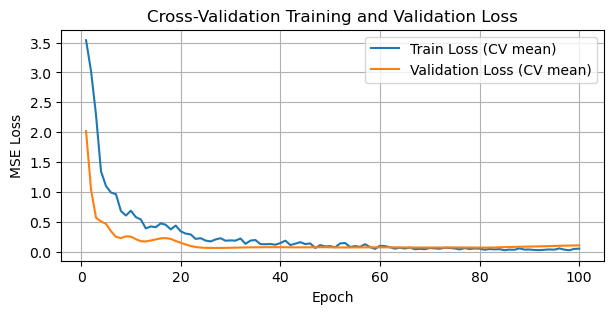

Epoch 10/100, Loss: 0.868554, Val Loss: 0.097646
Epoch 20/100, Loss: 0.260859, Val Loss: 0.033862
Epoch 30/100, Loss: 0.205094, Val Loss: 0.020261
Epoch 40/100, Loss: 0.216840, Val Loss: 0.031475
Epoch 50/100, Loss: 0.073404, Val Loss: 0.022289
Epoch 60/100, Loss: 0.107212, Val Loss: 0.043094
Epoch 70/100, Loss: 0.077881, Val Loss: 0.035730
Epoch 80/100, Loss: 0.045324, Val Loss: 0.037312
Epoch 90/100, Loss: 0.043001, Val Loss: 0.066621
Epoch 100/100, Loss: 0.043525, Val Loss: 0.092371


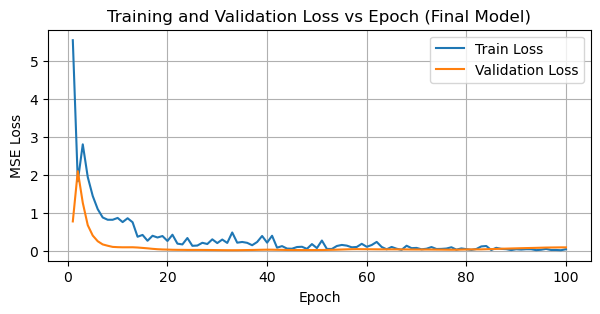

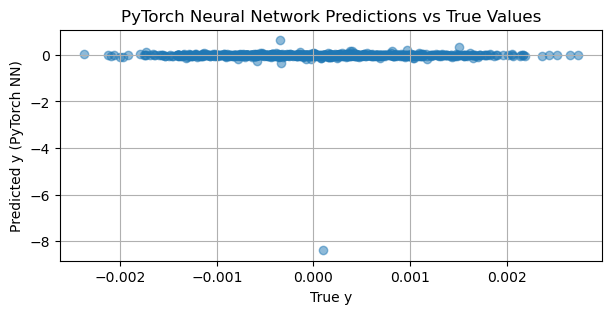

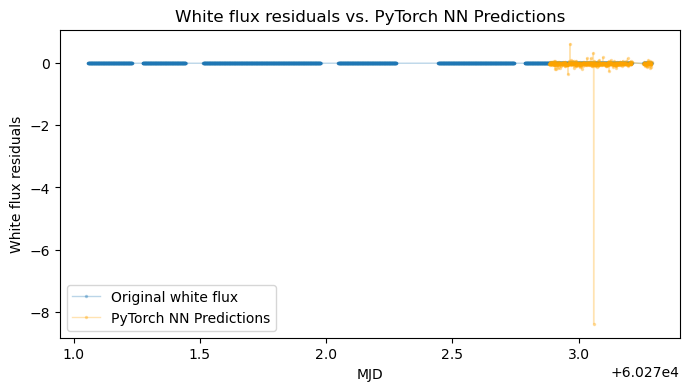

In [88]:
# Simple NN with lagged features
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np

# ---- Add lagged features ----
def create_lagged_features(df, feature_names, lags=[1, 2, 3]):
    df_lagged = df.copy()
    lagged_columns = []

    for lag in lags:
        lagged = df[feature_names].shift(lag)
        lagged.columns = [f"{col}_lag{lag}" for col in feature_names]
        lagged_columns.append(lagged)

    df_lagged = pd.concat([df] + lagged_columns, axis=1)
    df_lagged = df_lagged.dropna().reset_index(drop=True)
    return df_lagged


lags = [1, 2, 3]
ml_df_lagged = create_lagged_features(ml_df, feature_names, lags)
lagged_feature_names = feature_names.copy()
for lag in lags:
    lagged_feature_names += [f"{col}_lag{lag}" for col in feature_names]
X_lag = ml_df_lagged[lagged_feature_names].values
y_lag = y[-len(ml_df_lagged):]  # align target

print(X_lag.shape)
print(y_lag.shape)

# ---- Neural network model ----
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 96),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

# ---- Cross-validation ----
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv_train_losses, cv_val_losses = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_lag)):
    print(f"Fold {fold+1}/{n_splits}")
    X_train_cv, X_val_cv = X_lag[train_idx], X_lag[val_idx]
    y_train_cv, y_val_cv = y_lag[train_idx], y_lag[val_idx]

    X_train_cv_torch = torch.tensor(X_train_cv, dtype=torch.float32)
    X_val_cv_torch = torch.tensor(X_val_cv, dtype=torch.float32)
    y_train_cv_torch = torch.tensor(y_train_cv, dtype=torch.float32).unsqueeze(1)
    y_val_cv_torch = torch.tensor(y_val_cv, dtype=torch.float32).unsqueeze(1)

    model_cv = SimpleNN(X_train_cv.shape[1])
    optimizer_cv = optim.Adam(model_cv.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion_cv = nn.MSELoss()

    train_losses, val_losses = [], []
    for epoch in range(100):
        model_cv.train()
        optimizer_cv.zero_grad()
        loss = criterion_cv(model_cv(X_train_cv_torch), y_train_cv_torch)
        loss.backward()
        optimizer_cv.step()
        train_losses.append(loss.item())

        model_cv.eval()
        with torch.no_grad():
            val_loss = criterion_cv(model_cv(X_val_cv_torch), y_val_cv_torch)
            val_losses.append(val_loss.item())
    cv_train_losses.append(train_losses)
    cv_val_losses.append(val_losses)
    print(f"  Final Train Loss: {train_losses[-1]:.6f}, Final Val Loss: {val_losses[-1]:.6f}")

# ---- Plot cross-validation loss ----
plt.figure(figsize=(7, 3))
plt.plot(range(1, 101), np.mean(cv_train_losses, axis=0), label='Train Loss (CV mean)')
plt.plot(range(1, 101), np.mean(cv_val_losses, axis=0), label='Validation Loss (CV mean)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Cross-Validation Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# ---- Final train/test split ----
X_train, X_test, y_train, y_test = train_test_split(X_lag, y_lag, test_size=0.2, random_state=42)
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

model = SimpleNN(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
train_losses, val_losses = [], []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    loss = criterion(model(X_train_torch), y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_test_torch), y_test_torch)
        val_losses.append(val_loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/100, Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

# ---- Final training loss plot ----
plt.figure(figsize=(7, 3))
plt.plot(range(1, 101), train_losses, label='Train Loss')
plt.plot(range(1, 101), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss vs Epoch (Final Model)')
plt.legend()
plt.grid()
plt.show()

# ---- Predictions and final plots ----
model.eval()
with torch.no_grad():
    y_pred_pt = model(X_test_torch).squeeze().numpy()

plt.figure(figsize=(7, 3))
plt.scatter(y_test, y_pred_pt, alpha=0.5)
plt.xlabel('True y')
plt.ylabel('Predicted y (PyTorch NN)')
plt.title('PyTorch Neural Network Predictions vs True Values')
plt.grid()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(mjd_lightcurve[-len(y):], y, '.-', label='Original white flux', alpha=0.3, markersize=3, linewidth=1)
plt.plot(mjd_lightcurve[-len(y):][-len(y_pred_pt):], y_pred_pt, '.-', label='PyTorch NN Predictions', color='orange', alpha=0.3, markersize=3, linewidth=1)
plt.xlabel('MJD')
plt.ylabel('White flux residuals')
plt.title('White flux residuals vs. PyTorch NN Predictions')
plt.legend()
plt.show()


(3906, 900)
(3906,)
Fold 1 done. Final Train Loss: 0.332323, Val Loss: 0.024113
Fold 2 done. Final Train Loss: 0.615251, Val Loss: 0.124118
Fold 3 done. Final Train Loss: 0.779850, Val Loss: 0.681214
Fold 4 done. Final Train Loss: 0.937918, Val Loss: 0.108760
Fold 5 done. Final Train Loss: 0.985642, Val Loss: 0.095213


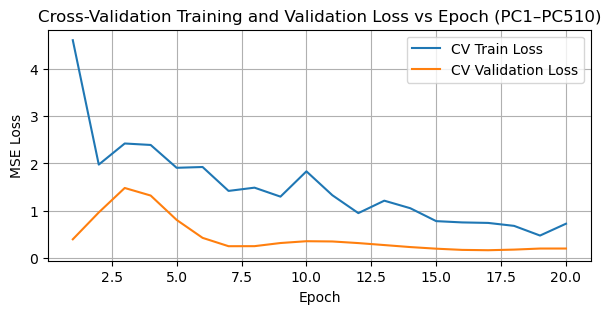

Epoch 10/20, Loss: 2.213507, Val Loss: 1.057857
Epoch 20/20, Loss: 0.468960, Val Loss: 0.435092


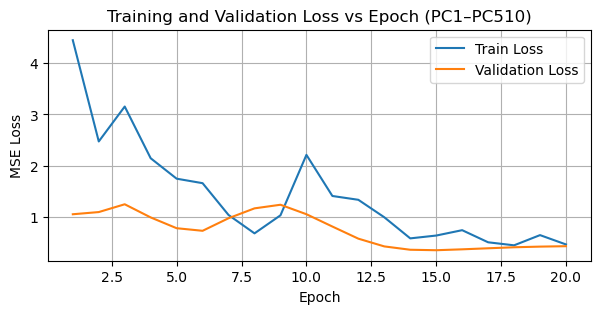

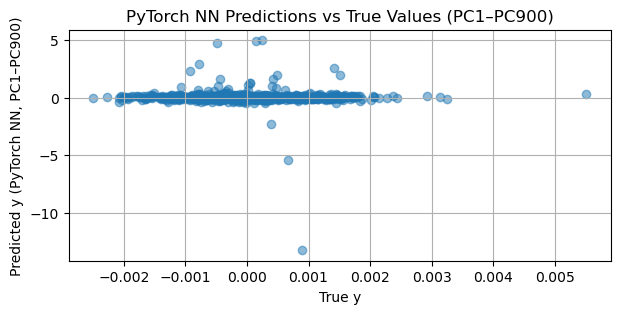

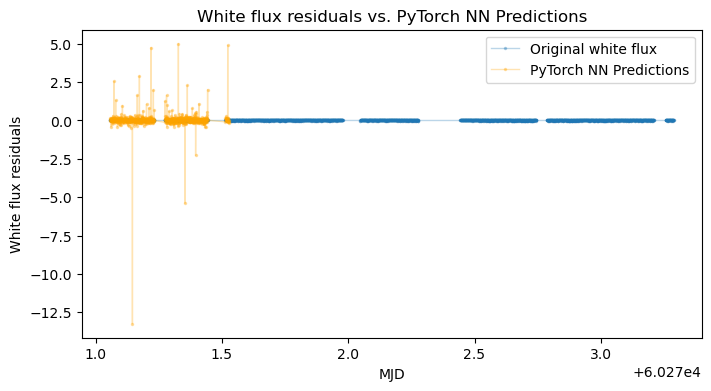

In [84]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import torch.nn as nn
import torch.optim as optim

# Use first 450 principal components as features
n_pc = 900
X_pca_n = X_pca[:, :n_pc]

print(X_pca_n.shape)
print(y.shape)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_pca_n, y, test_size=0.2, random_state=42
)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


# Define neural network for final training
class PCANN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 96),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(96, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PCANN(n_pc)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_train_losses = []
cv_val_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_train_cv = torch.tensor(X_train[train_idx], dtype=torch.float32)
    y_train_cv = torch.tensor(y_train[train_idx], dtype=torch.float32).unsqueeze(1)
    X_val_cv = torch.tensor(X_train[val_idx], dtype=torch.float32)
    y_val_cv = torch.tensor(y_train[val_idx], dtype=torch.float32).unsqueeze(1)

    model_cv = PCANN(n_pc)
    criterion_cv = nn.MSELoss()
    optimizer_cv = optim.Adam(model_cv.parameters(), lr=1e-3, weight_decay=1e-4)

    epochs_cv = 20
    train_losses_cv = []
    val_losses_cv = []
    for epoch in range(epochs_cv):
        model_cv.train()
        optimizer_cv.zero_grad()
        output_cv = model_cv(X_train_cv)
        loss_cv = criterion_cv(output_cv, y_train_cv)
        loss_cv.backward()
        optimizer_cv.step()
        train_losses_cv.append(loss_cv.item())
        model_cv.eval()
        with torch.no_grad():
            val_loss_cv = criterion_cv(model_cv(X_val_cv), y_val_cv)
            val_losses_cv.append(val_loss_cv.item())
    cv_train_losses.append(train_losses_cv)
    cv_val_losses.append(val_losses_cv)
    print(f"Fold {fold+1} done. Final Train Loss: {train_losses_cv[-1]:.6f}, Val Loss: {val_losses_cv[-1]:.6f}")

# Plot average CV loss vs epoch
plt.figure(figsize=(7, 3))
plt.plot(range(1, epochs_cv+1), np.mean(cv_train_losses, axis=0), label='CV Train Loss')
plt.plot(range(1, epochs_cv+1), np.mean(cv_val_losses, axis=0), label='CV Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Cross-Validation Training and Validation Loss vs Epoch (PC1–PC510)')
plt.legend()
plt.grid()
plt.show()

# Training loop
epochs = 20
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = criterion(output, y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_test_torch), y_test_torch)
        val_losses.append(val_loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")

# Plot loss vs epoch
plt.figure(figsize=(7, 3))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss vs Epoch (PC1–PC510)')
plt.legend()
plt.grid()
plt.show()

# Predict on the test set
model.eval()
with torch.no_grad():
    y_pred_pt = model(X_test_torch).squeeze().numpy()

# Plot predictions vs true values
plt.figure(figsize=(7, 3))
plt.scatter(y_test, y_pred_pt, alpha=0.5)
plt.xlabel('True y')
plt.ylabel(f'Predicted y (PyTorch NN, PC1–PC{n_pc})')
plt.title(f'PyTorch NN Predictions vs True Values (PC1–PC{n_pc})')
plt.grid()
plt.show()

# Plot the reconstructed vs. original white flux
plt.figure(figsize=(8, 4))
plt.plot(mjd_lightcurve, y, '.-', label='Original white flux', alpha=0.3, markersize=3, linewidth=1)
plt.plot(mjd_lightcurve[:len(y_pred_pt)], y_pred_pt, '.-', label='PyTorch NN Predictions', color='orange', alpha=0.3, markersize=3, linewidth=1)
plt.xlabel('MJD')
plt.ylabel('White flux residuals')
plt.title('White flux residuals vs. PyTorch NN Predictions')
plt.legend()
plt.show()